In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
session = 'ALTAI_20240822_SESSION_00'
path = '/Volumes/data2/eTheremin/ALTAI/'+ session + '/'

In [110]:

# Chemin du fichier .pkl
tt_path = path + 'headstage_0/tt.pkl'

# Ouvrir et charger le fichier .pkl
with open(tt_path, 'rb') as file:  # 'rb' signifie read-binary (lecture en binaire)
    tt = pickle.load(file)

spk_times = np.load(path + 'headstage_0/spike_times.npy')
spk_clusters = np.load(path + 'headstage_0/spike_clusters.npy')


In [ ]:
import numpy as np

def compute_psth(spike_times, stimulus_times, bin_size, window, sr):
    """
    Calculate independent PSTHs for each stimulus time.

    Parameters:
    - spike_times: Array of spike times in seconds.
    - stimulus_times: Array of stimulus times in seconds.
    - bin_size: Size of the bins for the histogram.
    - window: Time window around the stimulus to consider (tuple of (start, end)).
    - sr: Sampling rate for converting times if needed.

    Returns:
    - psth_list: List of PSTHs for each stimulus.
    - bin_edges: The edges of the bins used.
    """
    # Convert stimulus and spike times to seconds if not already
    if np.issubdtype(type(stimulus_times), np.number):
        stimulus_times = stimulus_times / sr  # if stimulus_times is an array of numbers
    else:
        stimulus_times = np.array([x / sr for x in stimulus_times])  # if stimulus_times is a list

    spike_times = spike_times / sr  # Convert spike times to seconds
    psth_list = []
    
    # For each stimulus, compute the PSTH independently
    for stim_time in stimulus_times:
        # Get spikes relative to the current stimulus time
        relative_spikes = spike_times - stim_time
        # Select spikes that fall within the specified window
        selected_spikes = relative_spikes[(relative_spikes >= window[0]) & (relative_spikes <= window[1])]
        
        # Create histogram for selected spikes
        bins = np.arange(window[0], window[1] + bin_size, bin_size)
        hist, bin_edges = np.histogram(selected_spikes, bins=bins)
        
        # Store the histogram as a PSTH
        psth_list.append(hist)
    
    return psth_list, bin_edges


In [ ]:

an_times = np.array(tt['triggers'])
tones = np.array(tt['tones'])
conditions = np.array(tt['condition'])
sr = 30000
#PLOT
t_pre = 0.3#
t_post = 0.50#0.300
bin_width = 0.1
# Créer les bins de temps"
psth_bins = np.arange(-t_pre, t_post, bin_width)
window = [-t_pre, t_post]


clusters = {}
for value, cluster in zip(spk_times, spk_clusters):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(value)
for cluster, values in clusters.items():
    print(f"Cluster {cluster}: {len(values)}")


tracking, playback = [], []

tracking_stim_times = an_times[conditions == 0]
playback_stim_times = an_times[conditions == 1]
    #
for cluster in range(32):
    spike_times = np.array(clusters[cluster])
    tr_psth,tr_edges = compute_psth(spike_times, tracking_stim_times, bin_width, window, sr)
    tracking.append(tr_psth)

    pb_psth,pb_edges = compute_psth(spike_times, playback_stim_times, bin_width, window, sr)
    playback.append(pb_psth)

Cluster 2: 91760
Cluster 4: 48162
Cluster 22: 33724
Cluster 3: 152854
Cluster 25: 211873
Cluster 1: 126354
Cluster 20: 172073
Cluster 15: 146998
Cluster 14: 287652
Cluster 26: 104888
Cluster 6: 96121
Cluster 7: 226662
Cluster 23: 107872
Cluster 27: 36827
Cluster 8: 176104
Cluster 18: 16098
Cluster 31: 53727
Cluster 16: 78327
Cluster 0: 114531
Cluster 21: 135624
Cluster 24: 38413
Cluster 11: 13544
Cluster 5: 81351
Cluster 28: 110676
Cluster 13: 41371
Cluster 9: 42906
Cluster 29: 40785
Cluster 10: 23049
Cluster 17: 27543
Cluster 30: 30808
Cluster 12: 10152
Cluster 19: 11524


In [ ]:
tracking_transpose = np.moveaxis(tracking, 1, 0)     # ici matrice transposée dans le bon format  : n_trigs x n_clus x n_bins
playback_transpose = np.moveaxis(playback, 1, 0) 
X_total = np.vstack((tracking_transpose, playback_transpose)) # tracking et playback concaténés

y_tracking = np.zeros(len(tracking_transpose))
y_playback = np.ones(len(playback_transpose))
y = np.hstack((y_tracking,y_playback ))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy_total = []
for k in range(len(psth_bins)):
    X = X_total[:, :, k]


    # Étape 3: Séparer les données en ensemble d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Étape 4: Standardiser les données
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Étape 5: Entraîner un modèle (Random Forest dans cet exemple)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Étape 6: Faire des prédictions
    y_pred = model.predict(X_test_scaled)

    # Étape 7: Évaluer le modèle
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_total.append(accuracy)
    print("Exactitude (accuracy):", accuracy)

Exactitude (accuracy): 0.766403162055336
Exactitude (accuracy): 0.7549407114624506
Exactitude (accuracy): 0.7774703557312252
Exactitude (accuracy): 0.7660079051383399
Exactitude (accuracy): 0.7818181818181819
Exactitude (accuracy): 0.7818181818181819
Exactitude (accuracy): 0.7703557312252964
Exactitude (accuracy): 0.7735177865612648


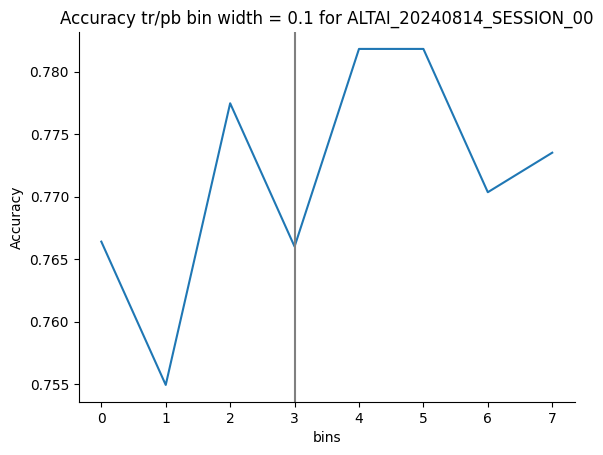

In [ ]:
plt.plot(accuracy_total)
plt.axvline(t_pre/bin_width, c='grey')
plt.title(f'Accuracy tr/pb bin width = {bin_width} for {session}')
plt.xlabel('bins')
plt.ylabel('Accuracy')

# Retirer les bordures droite et haute
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


In [ ]:
import numpy as np

def compute_psth_tones(spike_times, stimulus_times, tones, bin_size, window, sr):
    """
    Calculate independent PSTHs for each stimulus time, including associated tones.

    Parameters:
    - spike_times: Array of spike times in seconds.
    - stimulus_times: Array of stimulus times in seconds.
    - tones: Array of tones associated with each stimulus time.
    - bin_size: Size of the bins for the histogram.
    - window: Time window around the stimulus to consider (tuple of (start, end)).
    - sr: Sampling rate for converting times if needed.

    Returns:
    - psth_list: List of PSTHs for each stimulus.
    - bin_edges: The edges of the bins used.
    - tone_list: List of tones associated with each PSTH.
    - trigger_times: List of trigger times associated with each PSTH.
    """
    # Convert stimulus and spike times to seconds if not already
    if np.issubdtype(type(stimulus_times), np.number):
        stimulus_times = stimulus_times / sr  # if stimulus_times is an array of numbers
    else:
        stimulus_times = np.array([x / sr for x in stimulus_times])  # if stimulus_times is a list

    spike_times = spike_times / sr  # Convert spike times to seconds
    psth_list = []
    tone_list = []  # To store associated tones
    trigger_times = []  # To store corresponding trigger times
    
    # For each stimulus, compute the PSTH independently
    for i, stim_time in enumerate(stimulus_times):
        # Get spikes relative to the current stimulus time
        relative_spikes = spike_times - stim_time
        # Select spikes that fall within the specified window
        selected_spikes = relative_spikes[(relative_spikes >= window[0]) & (relative_spikes <= window[1])]
        
        # Create histogram for selected spikes
        bins = np.arange(window[0], window[1] + bin_size, bin_size)
        hist, bin_edges = np.histogram(selected_spikes, bins=bins)
        
        # Store the histogram as a PSTH
        psth_list.append(hist)
        tone_list.append(tones[i])  # Store the associated tone
        trigger_times.append(stim_time)  # Store the corresponding trigger time
    
    return psth_list, bin_edges, tone_list, trigger_times
